# Ionospheric Connection Explorer (ICON) on Jupyter Notebook

![caption](files/ICON_banner.png)
<br>
<br>
## Introduction of the science products 
- See full data product and ICON news on the website: https://icon.ssl.berkeley.edu/

The Ionospheric Connection Explorer, or ICON, is a new NASA Explorer mission
that will explore the boundary between Earth and space to understand the
physical connection between our world and our space environment. 
<br>
- L2.2 MIGHTI--Neutral Vector Winds -- Zonal Wind & Meridional Wind 
- L2.3 MIGHTI--Neutral Temperature
- L2.4 FUV--Column O/$N_{2}$
- L2.5 FUV--Nighttime $O^{+}$ Density 
- L2.6 EUV--Daytime $O^{+}$ Density
- L2.7 IVM--Ion Drift/Ion Densities/Ion Temperature 

## Note:
- Use flag
- Orbit number is not an integer in L2.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
from datetime import datetime, timedelta
import bisect
import netCDF4

import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator


import cartopy.crs as ccrs
import cartopy

plt.style.use('seaborn')

In [2]:
def get_linear_interpolation_from_twosides(sub_var_profile,sub_alt_profile,tar_alt_cm):
    grid_alt=tar_alt_cm
    output_var=sub_var_profile[0]+(sub_var_profile[-1]-sub_var_profile[0])*(grid_alt-sub_alt_profile[0])/(sub_alt_profile[-1]-sub_alt_profile[0])
    return output_var

# 1. Plot a single orbit--use L2.3 Temperature as an example

In [5]:
MTAB='A'
fn_L23 = 'Example_L23_Temperature.NC'

#### Load Temperature ###
dTN = {}
with netCDF4.Dataset(fn_L23) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dTN['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dTN['TN']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Temperature' % (MTAB)][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
    dTN['mlat']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Magnetic_Longitude' % (MTAB)][...], np.nan) # Magnetic latitude
    dTN['tang_slt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Solar_Local_Time' % (MTAB)][...], np.nan) # Local solar time
    dTN['tang_alt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Altitude' % (MTAB)][...], np.nan) # Altitude of the tangent point
    dTN['tang_lat']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Latitude' % (MTAB)][...], np.nan) # Latitude of the tangent point
    dTN['tang_lon']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Longitude' % (MTAB)][...], np.nan) # Longitude of the tangent point

    dTN['SC_lat']   = np.ma.filled(d.variables['ICON_L23_Observatory_Latitude'][...], np.nan) # Spacecraft Latitude
    dTN['SC_lon']   = np.ma.filled(d.variables['ICON_L23_Observatory_Longitude'][...], np.nan) # Spacecraft Longitude

    dTN['orb_num'] = np.ma.filled(d.variables['ICON_L23_Orbit_Number'][...], np.nan) # Orbit number

    # Simple quality control
    saa_flag  = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_South_Atlantic_Anomaly' % (MTAB)][...], np.nan) # SAA flag
    cali_flag = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_Bad_Calibration' % (MTAB)][...], np.nan) # Calibration flag

    good_data = (saa_flag == 0) & (cali_flag == 0)# This requires high current and negligible photoemission
    dTN['time'][~good_data] = np.nan # only good data are shown
    dTN['TN'][:,~good_data] = np.nan # only good data are shown
    
print('Range of the orbit number: %04i to %04i' % (np.nanmin(dTN['orb_num']),np.nanmax(dTN['orb_num'])))

Range of the orbit number: 1300 to 1315


In [7]:
# Select a particular orbit
target_orbit_num = 1302
select_orb_num_idx = np.argwhere(dTN['orb_num']== target_orbit_num)
select_orb_num_idx = select_orb_num_idx[:,0]

select_orb_num = dTN['orb_num'][select_orb_num_idx]
select_time = dTN['time'][select_orb_num_idx]
select_TN = dTN['TN'][:,select_orb_num_idx]
select_tang_slt = dTN['tang_slt'][:,select_orb_num_idx]
select_tang_lon = dTN['tang_lon'][:,select_orb_num_idx]
select_tang_lat = dTN['tang_lat'][:,select_orb_num_idx]
select_tang_alt = dTN['tang_alt'][:,select_orb_num_idx]
select_SC_lon = dTN['SC_lon'][select_orb_num_idx]
select_SC_lat = dTN['SC_lat'][select_orb_num_idx]

# Rearrange "select_TN" in the fixed altitude grids
new_altitude = np.array(range(0,11))*3.+93

New_alt_Epoch_ICON_TN_array=np.zeros((np.size(new_altitude), np.size(select_time)))+np.nan
for tidx in range(0,np.size(select_time)):
    sub_ICON_ALT=select_tang_alt[:,tidx]
    sub_ICON_var=select_TN[:,tidx]

    for sel_alt_idx in range(0,np.size(new_altitude)):
        Alt_layer=new_altitude[sel_alt_idx]
        ICON_alt_min_idx=np.argmin((np.abs(sub_ICON_ALT-Alt_layer)))
        if Alt_layer <= np.nanmax(sub_ICON_ALT):
            if not (sub_ICON_ALT[ICON_alt_min_idx]==Alt_layer):
                if (sub_ICON_ALT[ICON_alt_min_idx]-Alt_layer > 0):
                    ICON_sub_var_profile=[sub_ICON_var[ICON_alt_min_idx-1],sub_ICON_var[ICON_alt_min_idx]]
                    ICON_sub_alt_profile=[sub_ICON_ALT[ICON_alt_min_idx-1],sub_ICON_ALT[ICON_alt_min_idx]]

                if (sub_ICON_ALT[ICON_alt_min_idx]-Alt_layer < 0):
                    ICON_sub_var_profile=[sub_ICON_var[ICON_alt_min_idx],sub_ICON_var[ICON_alt_min_idx+1]]
                    ICON_sub_alt_profile=[sub_ICON_ALT[ICON_alt_min_idx],sub_ICON_ALT[ICON_alt_min_idx+1]]
                    
                New_alt_Epoch_ICON_TN_array[sel_alt_idx,tidx]=get_linear_interpolation_from_twosides(ICON_sub_var_profile,ICON_sub_alt_profile,Alt_layer)
            else:
                New_alt_Epoch_ICON_TN_array[sel_alt_idx,tidx]=sub_ICON_var[sel_alt_idx]

        else:
            New_alt_Epoch_ICON_TN_array[sel_alt_idx,tidx]=sub_ICON_var[np.nanargmax(sub_ICON_ALT)]

Res_alt_Epoch_ICON_TN_array=np.zeros((np.size(new_altitude), np.size(select_time)))+np.nan
for mean_idix in range(0,np.size(new_altitude)):
    Res_alt_Epoch_ICON_TN_array[mean_idix,:]= New_alt_Epoch_ICON_TN_array[mean_idix,:]-np.nanmean( New_alt_Epoch_ICON_TN_array[mean_idix,:])

print('Rearranging TN in fixed altitude grids is completed!')

Rearranging TN in fixed altitude grids is completed!


/home/yjwu/miniconda3/envs/my_conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/yjwu/miniconda3/envs/my_conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


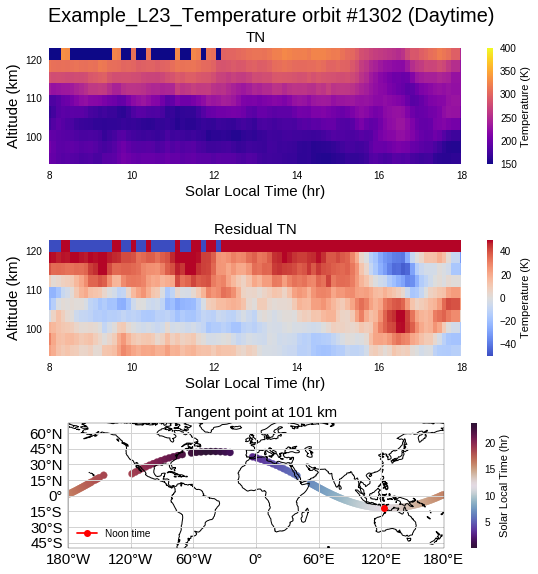

In [13]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdatesa
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


NC_fname_split=re.split('/|.NC',fn_L23)
plot_fname=NC_fname_split[-2]

## Temperature ###
target_1_array=New_alt_Epoch_ICON_TN_array
cmap_1='plasma'
vmax_1=400
vmin_1=150
variable_name_1='TN'
xlabel_1='Solar Local Time (hr)'
ylabel_1='Altitude (km)'
cb_label_1='Temperature (K)'
tang_alt_idx=5

### Temperature residual= Temperature substract by the zonal daily mean in the same altitude
target_2_array=Res_alt_Epoch_ICON_TN_array
cmap_2='coolwarm'
vmax_2=50
vmin_2=-50
variable_name_2='Residual TN'
xlabel_2='Solar Local Time (hr)'
ylabel_2='Altitude (km)'
cb_label_2='Temperature (K)'

######################## PLOT #############################
plt.rcParams.update({
    "font.size": 22,
    "lines.color": "black",
    "patch.edgecolor": "black",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})
X, Y = np.meshgrid(select_tang_slt[3,:],new_altitude)
fig,ax=plt.subplots(figsize=(8,8))#fig=pp.figure(figsize=(12,10)

fig.suptitle('%s orbit #%04i (Daytime)'% (plot_fname,select_orb_num[1]),size=20)
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 


ax0=plt.subplot(gs[0,0])
#im = ax0.pcolor(X,Y, MA_daily_dev_array,cmap='plasma',norm=colors.Normalize(vmin=0, vmax=150))
im = ax0.pcolor(X,Y,target_1_array ,cmap=cmap_1,vmin=vmin_1,vmax=vmax_1)#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.axis([8,18,Y.min(),Y.max()])

ax0.set_title(variable_name_1,size=15)
ax0.set_xlabel(xlabel_1,size=15)
ax0.set_ylabel(ylabel_1,size=15)

color_bar=fig.colorbar(im)
color_bar.set_label(cb_label_1)

ax0=plt.subplot(gs[1,0])
#im = ax0.pcolor(X,Y, MA_daily_dev_array,cmap='plasma',norm=colors.Normalize(vmin=0, vmax=150))
im = ax0.pcolor(X,Y,target_2_array ,cmap=cmap_2,vmin=vmin_2,vmax=vmax_2)#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.axis([8,18,Y.min(),Y.max()])

ax0.set_title(variable_name_2,size=15)
ax0.set_xlabel(xlabel_2,size=15)
ax0.set_ylabel(ylabel_2,size=15)

color_bar=fig.colorbar(im)
color_bar.set_label(cb_label_2)


plt.tight_layout(rect=[0, 0.0, 1., 0.99])


gs_map = gridspec.GridSpec(1, 1)
ax_list = [fig.add_subplot(ss,projection=ccrs.PlateCarree(),extent=[-179.9999,180,-50,70]) for ss in gs_map]

ax_list[0].coastlines(color='black', linewidth=1)
#ax.gridlines()

gl = ax_list[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)#,

gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
gs_map.tight_layout(fig,rect=[0.0, 0.0, 1.03, 0.3],h_pad=0.5)
noon_idx=np.argmin(np.abs(select_tang_slt[2,:]-12))
im=ax_list[0].scatter(select_tang_lon[tang_alt_idx,:],select_tang_lat[tang_alt_idx,:],c=select_tang_slt[tang_alt_idx,:],cmap='twilight_shifted')
ax_list[0].set_title('Tangent point at %03i km' % select_tang_alt[tang_alt_idx,1],size=15)
if (select_tang_lon[tang_alt_idx,noon_idx] > 180):
    noon_lon=select_tang_lon[tang_alt_idx,noon_idx]-360.
else:
    noon_lon=select_tang_lon[tang_alt_idx,noon_idx]
ax_list[0].plot(noon_lon,select_tang_lat[tang_alt_idx,noon_idx],marker='o',color='red',label='Noon time')
color_bar=fig.colorbar(im)
color_bar.set_label('Solar Local Time (hr)')

plt.tight_layout(rect=[0, 0.0, 1.05, 0.98])

plt.legend(loc='lower left')

# 2. IVM-MIGHTI 
- Neutral wind driven electrodynamic interactions

In [22]:
fn_L22 ='Example_L22_Wind.NC'
fn_L27 ='Example_L27_IVM.NC'
#### Load ion velocity
di = {}
with netCDF4.Dataset(fn_L27) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    di['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    di['vmer']  = np.ma.filled(d.variables['ICON_L27_Ion_Velocity_Meridional'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
    di['mlat']  = np.ma.filled(d.variables['ICON_L27_Magnetic_Latitude'][...], np.nan) # Magnetic latitude
    di['slt']   = np.ma.filled(d.variables['ICON_L27_Solar_Local_Time'][...], np.nan) # Local solar time
    di['alt']   = np.ma.filled(d.variables['ICON_L27_Altitude'][...], np.nan) # Local solar time
    di['orb_num']   = np.ma.filled(d.variables['ICON_L27_Orbit_Number'][...], np.nan) # Local solar time

    # Simple quality control
    curr0  = np.ma.filled(d.variables['ICON_L27_low_log_level_currents_0'][...], np.nan) # Quality control variable
    curr1  = np.ma.filled(d.variables['ICON_L27_low_log_level_currents_1'][...], np.nan) # Quality control variable
    photoy = np.ma.filled(d.variables['ICON_L27_photo_flag_y'][...], np.nan) # Quality control variable
    photoz = np.ma.filled(d.variables['ICON_L27_photo_flag_z'][...], np.nan) # Quality control variable
    good_data = (curr0 == 0) & (curr1 == 0) & (photoy == 0) & (photoz == 0) # This requires high current and negligible photoemission
    di['mlat'][~good_data] = np.nan
    
#### Load winds
dm = {}
with netCDF4.Dataset(fn_L22) as d:
    time_msec  = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dm['time'] = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dm['uzon'] = np.ma.filled(d.variables['ICON_L22_Zonal_Wind'][...], np.nan)
    dm['umer'] = np.ma.filled(d.variables['ICON_L22_Meridional_Wind'][...], np.nan)
    dm['alt']  = np.ma.filled(d.variables['ICON_L22_Altitude'][...], np.nan)
    
    # Simple quality control
    wind_quality = np.ma.filled(d.variables['ICON_L22_Wind_Quality'][...], np.nan)
    good_data = wind_quality == 1
    dm['uzon'][~good_data] = np.nan
    dm['umer'][~good_data] = np.nan

print('Loading %s and %s are completed!' % (fn_L22,fn_L27))
print('Range of the orbit number: %04i to %04i' % (np.nanmin(di['orb_num']),np.nanmax(di['orb_num'])))

Loading Example_L22_Wind.NC and Example_L27_IVM.NC are completed!
Range of the orbit number: 2197 to 2212


In [11]:
#### Find first equator crossing during daytime 
icon_near_equator = (abs(di['mlat']) < 1.) # ICON is within 1 degree of equator
daytime = abs(di['slt'] - 12) < 6 # ICON is in daytime hours
ii = np.where( icon_near_equator & daytime )[0][0] # index of first IVM sample
t0 = di['time'][ii]
print('ICON near equator starting at %s' % t0)

# Find MIGHTI index that matches this time
# Note: in practice, the true MIGHTI-IVM conjunction may happen a couple minutes before or after this time.
# Magnetic field line tracing is recommended to find true conjunctions.
im = np.argmin(abs(dm['time'] - t0))

ICON near equator starting at 2020-03-06 01:27:28.224000


/home/yjwu/miniconda3/envs/my_conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


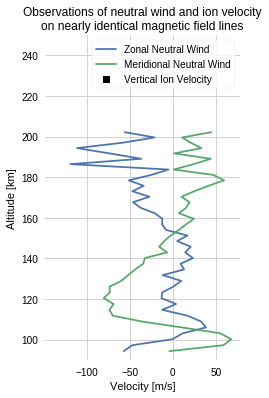

In [12]:
#### Plot the profiles ###
plt.figure(figsize=(4,6))

plt.plot(dm['uzon'][im,:], dm['alt'], 'C0-', label='Zonal Neutral Wind')
plt.plot(dm['umer'][im,:], dm['alt'], 'C1-', label='Meridional Neutral Wind')
plt.plot(di['vmer'][ii], di['alt'][ii], 'ks', label='Vertical Ion Velocity')
plt.ylabel('Altitude [km]')
plt.xlabel('Velocity [m/s]')
plt.title('Observations of neutral wind and ion velocity\non nearly identical magnetic field lines')
plt.ylim([90,250])
plt.legend(frameon=True)
plt.tight_layout()

# 3. IVM-EUV/FUV
- EUV and FUV provides the measurement of $O^+$ density, NmF2 and HmF2 in the ionosphere.
- FUV also provides column O/$N_2$

In [52]:
fn_L24 ='Example_L24_FUV_day.NC'
#Too Big!fn_L25 ='Example_L25_FUV_night.NC'
fn_L26 ='Example_L26_EUV.NC'


#  Load L2.4 disk O/N2 #
dON2 = {}
with netCDF4.Dataset(fn_L24) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dON2['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dON2['disk_ON2']  = np.ma.filled(d.variables['ICON_L24_disk_ON2'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
#     di['mlat']  = np.ma.filled(d.variables['ICON_L27_Magnetic_Latitude'][...], np.nan) # Magnetic latitude
    dON2['disk_slt']   = np.ma.filled(d.variables['ICON_L24_Local_Solar_Time_Disk'][...], np.nan) # Local solar time
    dON2['disk_lon']   = np.ma.filled(d.variables['ICON_L24_disk_longitude'][...], np.nan) # Local solar time
    dON2['disk_lat']   = np.ma.filled(d.variables['ICON_L24_disk_latitude'][...], np.nan) # Local solar time
    dON2['SC_lon']   = np.ma.filled(d.variables['ICON_L24_Observatory_Longitude'][...], np.nan) # Local solar time
    dON2['SC_lat']   = np.ma.filled(d.variables['ICON_L24_Observatory_Latitude'][...], np.nan) # Local solar time

    # Simple quality control
    model_flag  = np.ma.filled(d.variables['ICON_L24_Model_Disk_Flags'][...], np.nan) # Quality control variable
    instrument_flag  = np.ma.filled(d.variables['ICON_L24_Instrument_Mode_Flag'][...], np.nan) # Quality control variable
    L1_flag = np.ma.filled(d.variables['ICON_L24_Level_1_Quality_Flag'][...], np.nan) # Quality control variable
    good_data = ( model_flag[:,0] == 0) & ( instrument_flag == 1) & ( L1_flag== 0)# This requires high current and negligible photoemission
    dON2['disk_lon'][~good_data] = np.nan

# Load L2.6 Daytime plasma observations #
dEUV = {}
with netCDF4.Dataset(fn_L26) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dEUV['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dEUV['HmF2']  = np.ma.filled(d.variables['ICON_L26_HmF2'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
    dEUV['NmF2']  = np.ma.filled(d.variables['ICON_L26_NmF2'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
    dEUV['Oplus']  = np.ma.filled(d.variables['ICON_L26_Oplus'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
    dEUV['orb_num']  = np.ma.filled(d.variables['ICON_L26_Orbit_Number'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity

#     di['mlat']  = np.ma.filled(d.variables['ICON_L27_Magnetic_Latitude'][...], np.nan) # Magnetic latitude
    dEUV['tang_slt']   = np.ma.filled(d.variables['ICON_L26_Local_Solar_Time'][...], np.nan) # Local solar time
    dEUV['tang_lon']   = np.ma.filled(d.variables['ICON_L26_Longitude'][...], np.nan) # Local solar time
    dEUV['tang_lat']   = np.ma.filled(d.variables['ICON_L26_Latitude'][...], np.nan) # Local solar time
    dEUV['tang_mag_lon']   = np.ma.filled(d.variables['ICON_L26_Magnetic_Longitude'][...], np.nan) # Local solar time
    dEUV['tang_mag_lat']   = np.ma.filled(d.variables['ICON_L26_Magnetic_Latitude'][...], np.nan) # Local solar time

    dEUV['SC_lon']   = np.ma.filled(d.variables['ICON_L26_Observatory_Longitude'][...], np.nan) # Local solar time
    dEUV['SC_lat']   = np.ma.filled(d.variables['ICON_L26_Observatory_Latitude'][...], np.nan) # Local solar time

    # Simple quality control
    L26_flag  = np.ma.filled(d.variables['ICON_L26_Flags'][...], np.nan) # Quality control variable
    good_data = ( L26_flag == 1) # This requires high current and negligible photoemission
    dEUV['HmF2'][~good_data] = np.nan
    dEUV['NmF2'][~good_data] = np.nan
    dEUV['Oplus'][~good_data] = np.nan
    
print('Loading %s and %s are completed!' % (fn_L24,fn_L26))
print('Range of the orbit number: %04i to %04i' % (np.nanmin(dEUV['orb_num']),np.nanmax(dEUV['orb_num'])))

Loading Example_L24_FUV_day.NC and Example_L26_EUV.NC are completed!
Range of the orbit number: 2197 to 2212


In [53]:
target_orbit_num=2212

EUV_select_orb_num_idx = np.where(dEUV['orb_num']== target_orbit_num)
IVM_select_orb_num_idx = np.where(di['orb_num']== target_orbit_num)

# select_orb_num_idx = select_orb_num_idx[:,0]

# orbit_HmF2= dEUV['HmF2'][select_orb_num_idx]
# orbit_tang_lon= dEUV['tang_lon'][select_orb_num_idx]
# orbit_tang_lat= dEUV['HmF2'][select_orb_num_idx]
# orbit_HmF2= dEUV['HmF2'][select_orb_num_idx]
# orbit_HmF2= dEUV['HmF2'][select_orb_num_idx]


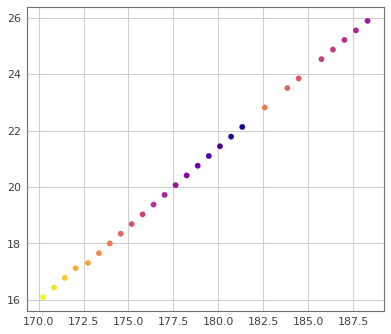

In [54]:
select_orb_num_idx
plt.close()
plt.scatter(dEUV['tang_lon'][select_orb_num_idx],dEUV['tang_lat'][select_orb_num_idx],c=dEUV['HmF2'][select_orb_num_idx],cmap='plasma')
plt.scatter(dEUV['tang_lon'][select_orb_num_idx],dEUV['tang_lat'][select_orb_num_idx],c=dEUV['HmF2'][select_orb_num_idx],cmap='plasma')

No handles with labels found to put in legend.


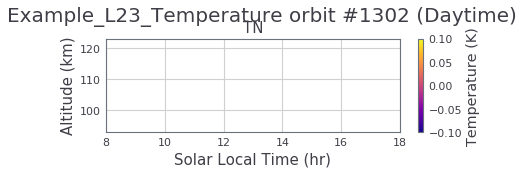

In [46]:
target_1_array=New_alt_Epoch_ICON_TN_array
cmap_1='plasma'
vmax_1=None
vmin_1=None
variable_name_1='TN'
xlabel_1='Solar Local Time (hr)'
ylabel_1='Altitude (km)'
cb_label_1='Temperature (K)'
tang_alt_idx=5


plt.close()
fig,ax=plt.subplots(figsize=(6,4))#fig=pp.figure(figsize=(12,10)
NC_fname_split=re.split('/|.NC',fn_L23)
plot_fname=NC_fname_split[-2]
fig.suptitle('%s orbit #%04i (Daytime)'% (plot_fname,select_orb_num[1]),size=20)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 


ax0=plt.subplot(gs[0,0])
#im = ax0.pcolor(X,Y, MA_daily_dev_array,cmap='plasma',norm=colors.Normalize(vmin=0, vmax=150))
im = ax0.scatter( dEUV['tang_lon'][select_orb_num_idx], dEUV['tang_lat'][select_orb_num_idx],c= dEUV['HmF2'][select_orb_num_idx] ,cmap=cmap_1,vmin=vmin_1,vmax=vmax_1)#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.axis([8,18,Y.min(),Y.max()])

ax0.set_title(variable_name_1,size=15)
ax0.set_xlabel(xlabel_1,size=15)
ax0.set_ylabel(ylabel_1,size=15)

color_bar=fig.colorbar(im)
color_bar.set_label(cb_label_1)


plt.tight_layout(rect=[0, 0.0, 1.05, 0.98])

plt.legend(loc='lower left')